In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
import copy
from scipy.stats import norm
from torch import nn

In [2]:
from laplace import Laplace

In [2]:
from torch.autograd.functional import hessian

In [3]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
a = np.array([2, 2])
mean = np.array([1, 1])
norm.pdf(a, loc=mean)

array([0.24197072, 0.24197072])

# MAML

In [5]:
#generating sinusoidal data
class SineTask():
  def __init__(self,amp,phase,min_x,max_x):
    self.phase=phase
    self.max_x=max_x
    self.min_x=min_x
    self.amp=amp
    
  def sample_data(self,size=1):
    x=np.random.uniform(self.max_x,self.min_x,size)
    y=self.true_sine(x)
    x=torch.tensor(x, dtype=torch.float).unsqueeze(1)
    y=torch.tensor(y, dtype=torch.float).unsqueeze(1)
    return x,y
  
  def true_sine(self,x):
    y=self.amp*np.sin(self.phase+x)
    return y

In [6]:
class SineDistribution():
  def __init__(self,min_amp,max_amp,min_phase,max_phase,min_x,max_x):
    self.min_amp=min_amp
    self.max_phase=max_phase
    self.min_phase=min_phase
    self.max_amp=max_amp
    self.min_x=min_x
    self.max_x=max_x
    
  def sample_task(self):
    amp = np.random.uniform(self.min_amp, self.max_amp)
    phase = np.random.uniform(self.min_phase, self.max_phase)
    return SineTask(amp, phase, self.min_x, self.max_x)

In [7]:
#defining our sine-net
class SineNet(nn.Module):
  def __init__(self):
    super(SineNet,self).__init__()
    self.net=nn.Sequential(OrderedDict([
            ('l1',nn.Linear(1,40)),
            ('relu1',nn.ReLU()),
            ('l2',nn.Linear(40,40)),
            ('relu2',nn.ReLU()),
            ('l3',nn.Linear(40,1))
        ]))
      
  # I implemented argforward() so that I could use a set of custom weights for evaluation. 
  # This is important for the "inner loop" in MAML where you temporarily update the weights
  # of the network for a task to calculate the meta-loss and then reset them for the next meta-task.
  def argforward(self,x,weights): 
    x=F.linear(x,weights[0],weights[1])
    x=F.relu(x)
    x=F.linear(x,weights[2],weights[3])           
    x=F.relu(x)
    x=F.linear(x,weights[4],weights[5])
    return x

In [69]:
def form_matrix(hess):
    list = []
    for i in range(len(hess)):
        list_int = []
        for j in range(len(hess[i])):
            list_int.append((hess[i][j]).item())
        list.append(list_int)
    hess_global = torch.tensor(list)
    return hess_global

In [94]:
class SineMAML():
    def __init__(self,net,alpha,beta,tasks,k,m,N,eta,num_metatasks):
        self.net=net
        self.weights=list(net.parameters())
        self.alpha=alpha
        self.beta=beta
        self.tasks=tasks
        self.k=k 
        self.m = m
        self.N = N
        self.eta = eta
        self.num_tasks_meta=num_metatasks
        self.criterion=nn.GaussianNLLLoss() #nn.MSELoss() #Important
        self.meta_optimiser=torch.optim.Adam(self.weights,self.beta)
        self.meta_losses=[]
        self.plot_every =100
        self.print_every = 100
        self.num_metatasks=num_metatasks
  
    def ML_Laplace(self, task):
        temp_weights=[w.clone() for w in self.weights]  #This is phi
        x,y=task.sample_data(size=self.N) #sampling D
        x=x.to(device)
        y=y.to(device)
        for i in range(5):
            output=self.net.argforward(x,temp_weights) #We get f(x)
            loss=self.criterion(output, y, torch.ones_like(y))  
            grads=torch.autograd.grad(loss,temp_weights)
            temp_weights = [w-self.alpha*g for w,g in zip(temp_weights,grads)]
        x_new, y_new = task.sample_data(size=self.m)
        x_new.to(device)
        y_new.to(device)
        output = self.net.argforward(x_new,temp_weights)
        metaloss = self.criterion(output, y_new, torch.ones_like(output))

        for i in range(len(y_new)):
            y_int = y_new[i]
            x_int = y_new[i]
            output_int = output[i]
            input = (output_int, y_int, torch.ones_like(output_int))
            hess = hessian(self.criterion,input)
            hess = form_matrix(hess)
            if i==0:
                hessian_global = hess
            else:
                hessian_global+=hess
            if torch.det(hess)!=0:
                print(torch.det(hessian_global))
        print((hessian_global))
        hessian_1 = torch.log(torch.det(hessian_global))
        hessian_2 = torch.tensor(self.eta)*hessian_1

        metaloss = metaloss+hessian_2
        
        return metaloss


    def outer_loop(self,num_epochs):
        total_loss=0
        for epoch in range(1,num_epochs+1):
            metaloss_sum=0
            for i in range(self.num_metatasks):
                task=self.tasks.sample_task()
                metaloss=self.ML_Laplace(task)
                metaloss_sum+=metaloss
            metagrads=torch.autograd.grad(metaloss_sum,self.weights) #c'est theta
            #important step
            for w,g in zip(self.weights,metagrads):
                w.grad=g
            ###############
            self.meta_optimiser.step()
            total_loss+=metaloss_sum.item()/self.num_metatasks
            if epoch % self.print_every == 0:
                print("{}/{}. loss: {}".format(epoch, num_epochs, total_loss / self.plot_every))
            if epoch%self.plot_every==0:
                self.meta_losses.append(total_loss/self.plot_every)
                total_loss = 0

In [95]:
sine_tasks=SineDistribution(0.1, 5, 0, np.pi, -5, 5)
net=SineNet()
net=net.to(device)
maml=SineMAML(net,alpha=0.01,beta=0.001,tasks=sine_tasks,k=5,m=3,N=5,eta=0.1, num_metatasks=10)

In [99]:
torch.det(torch.tensor([[ 3.0000, -3.0000,  2.1149],
        [-3.0000,  3.0000, -2.1149],
        [ 2.1149, -2.1149,  0.4804]]))

tensor(-0.3032)

In [96]:
maml.outer_loop(num_epochs=5)

tensor([[ 3.0000, -3.0000, -5.5023],
        [-3.0000,  3.0000,  5.5023],
        [-5.5023,  5.5023,  9.6820]])
tensor([[ 3.0000, -3.0000,  0.4210],
        [-3.0000,  3.0000, -0.4210],
        [ 0.4210, -0.4210,  2.1083]])
tensor([[ 3.0000, -3.0000,  0.2028],
        [-3.0000,  3.0000, -0.2028],
        [ 0.2028, -0.2028, -1.3143]])
tensor([[ 3.0000, -3.0000,  0.3401],
        [-3.0000,  3.0000, -0.3401],
        [ 0.3401, -0.3401, -1.3136]])
tensor([[ 3.0000, -3.0000, -0.0092],
        [-3.0000,  3.0000,  0.0092],
        [-0.0092,  0.0092, -1.4812]])
tensor([[ 3.0000, -3.0000,  0.9518],
        [-3.0000,  3.0000, -0.9518],
        [ 0.9518, -0.9518,  5.6146]])
tensor([[ 3.0000, -3.0000,  2.1077],
        [-3.0000,  3.0000, -2.1077],
        [ 2.1077, -2.1077,  1.0822]])
tensor([[ 3.0000, -3.0000,  0.1607],
        [-3.0000,  3.0000, -0.1607],
        [ 0.1607, -0.1607, -1.2868]])
tensor([[ 3.0000, -3.0000, -5.4381],
        [-3.0000,  3.0000,  5.4381],
        [-5.4381,  5.4381, 11.

In [87]:
torch.det(mat)

tensor(-9.0396)

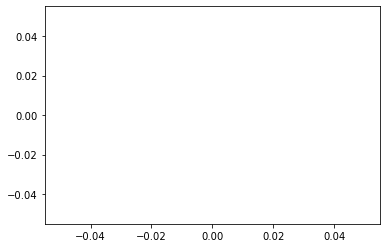

In [73]:
plt.plot(maml.meta_losses)

In [46]:
def test(og_net,x,y,lr,optim=torch.optim.SGD):
  axis=np.linspace(-5,5,1000)
  axis=torch.tensor(axis,dtype=torch.float)
  axis=axis.to(device)
  dummy_net = nn.Sequential(OrderedDict([
        ('l1', nn.Linear(1,40)),
        ('relu1', nn.ReLU()),
        ('l2', nn.Linear(40,40)),
        ('relu2', nn.ReLU()),
        ('l3', nn.Linear(40,1))
    ]))
  dummy_net=dummy_net.to(device)
  dummy_net.load_state_dict(og_net.state_dict())
  loss_fn=nn.GaussianNLLLoss()
  opt=optim(dummy_net.parameters(),lr=lr)
  num_shots=10
  k=x.shape[0]
  losses=[]
  outputs={}
  for i in range(num_shots):
    out=dummy_net(x)
    loss=loss_fn(out,y, torch.ones_like(y))
    losses.append(loss.item())
    dummy_net.zero_grad()
    loss.backward()
    opt.step()
  outputs['minitrained']= dummy_net(axis.view(-1, 1)).detach().cpu().clone().numpy()
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
  print(losses)
  return outputs,axis

In [47]:
def plot_test(og_net,x,y,task,optim=torch.optim.SGD,lr=0.01):
  outputs,axis=test(og_net,x,y,lr,optim)
  plt.figure(figsize=(10,5))
  plt.plot(axis.cpu().clone().numpy(),task.true_sine(axis.cpu().clone().numpy()), '-', color=(0, 0, 1, 0.5), label='true sine')
  plt.scatter(x.cpu().clone().numpy(), y.cpu().clone().numpy(), label='data')
  plt.plot(axis.cpu().clone().numpy(), outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
  plt.plot(axis.cpu().clone().numpy(), outputs['minitrained'], '-', color=(0.5, 0, 0, 1), label='minitrained weights')
  plt.legend(loc='lower right')
  plt.show()

[4.202057361602783, 1.8017921447753906, 0.7568591833114624, 0.4148148000240326, 0.32995539903640747, 0.27564191818237305, 0.23340943455696106, 0.1991472691297531, 0.1777169406414032, 0.16212883591651917]


<ipython-input-46-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()


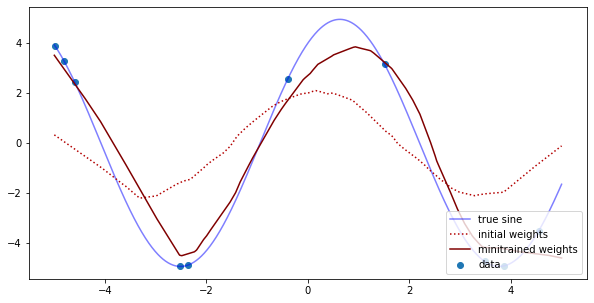

In [58]:
K=10
task=sine_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
plot_test(og_net=maml.net.net,x=x,y=y,task=task)

[0.276278018951416, 0.08018726110458374, 0.061088677495718, 0.04991734027862549, 0.04203770309686661, 0.03594667837023735, 0.03104306384921074, 0.027016444131731987, 0.023604238405823708, 0.020657215267419815]


<ipython-input-46-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()


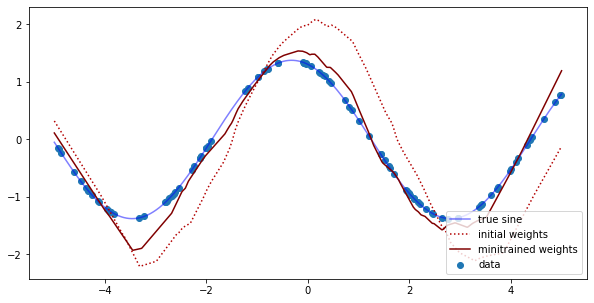

In [56]:
K=100
task=sine_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
plot_test(og_net=maml.net.net,x=x,y=y,task=task)

[1.358904242515564, 3.8795011043548584, 1.5800820589065552, 2.2632060050964355, 4.364636421203613, 6.851898670196533, 1.7153308391571045, 0.5533976554870605, 0.2388821393251419, 0.15983723104000092]


<ipython-input-23-c4cf0caec96c>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()


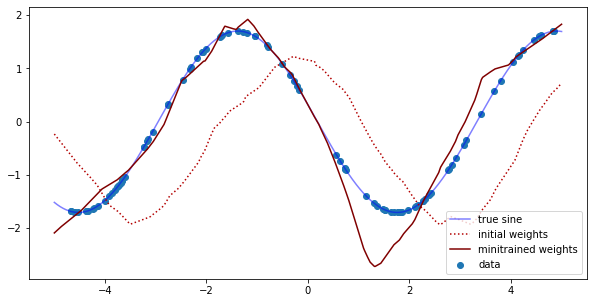

In [26]:
K=100
task=sine_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
plot_test(og_net=maml.net.net,x=x,y=y,task=task)

# Laplace avec les packages implémentés

In [ ]:
model = load_map_model()
la = Laplace(model, 'classification',
subset_of_weights='all',
hessian_structure='diag')
la.fit(train_loader)
la.optimize_prior_precision(method='CV',
val_loader=val_loader)

pred = la(x, pred_type='glm', link_approx='probit')

# Draft

In [ ]:
#Small tests

x_new, y_new = SineDistribution(0.1, 5, 0, np.pi, -5, 5).sample_task().sample_data(1)
x_new.to(device)
y_new.to(device)
temp_weights=list(net.parameters())
output = SineNet().argforward(x_new,temp_weights)
func = nn.GaussianNLLLoss()
metaloss = func(output, y_new, torch.ones_like(output))

input = (output, y_new, torch.ones_like(y_new))
hess = hessian(func, input)